In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import  json
import requests
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In [6]:
df  = pd.read_csv('neighborhood_toronto.csv')
col =  df.columns
df.drop(col[0],axis= 1 , inplace = True)
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [32]:
address  = 'Toronto, Toronto'
geolocator = Nominatim(user_agent="ny_explorer") # Should use another user_agent , but I will use it any way.
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.65238435, -79.38356765.


In [33]:

map_toronto  =  folium.Map(location =  [latitude,longitude])
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Sometimes the map above may not show it github or server . If you wantot see map download this notebook is a good option.

In [71]:
df.Borough.value_counts()


North York                24
Downtown Toronto          17
Scarborough               17
Etobicoke                 11
Central Toronto            9
West Toronto               6
York                       5
East York                  4
East Toronto               4
East York/East Toronto     1
Downtown Toronto Stn A     1
Queen's Park               1
East Toronto Business      1
Mississauga                1
Etobicoke Northwest        1
Name: Borough, dtype: int64

From instruction  :<br>
Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you. 

In [76]:
toronto  = df[df.Borough.str.contains(pat = 'Toronto')]
print(len(toronto))
toronto.head()


39


,Postal Code,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
40,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923


In [79]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
  
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list]) # In short it mean items in venue_list
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [80]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )

The Beaches
The Danforth  East
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Enclave of M5E
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High Park, The Junction 

In [82]:
print(toronto_venues.shape)
toronto_venues.head()

(1605, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Danforth East,43.685347,-79.338106,Aldwych Park,43.684901,-79.341091,Park


In [116]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

#move neighborhood column to the first column
temp = ['Neighborhood']
print(type(temp))
temp2 = list(toronto_onehot.columns[:])
temp2.remove('Neighborhood')
fixed_columns = temp  + temp2
toronto_onehot = toronto_onehot[fixed_columns]
print(toronto_onehot.shape)
toronto_onehot.head()


<class 'list'>
(1605, 230)


,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

In [118]:
grouped =  toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [120]:
print(grouped.shape)
grouped.head()

(39, 230)


,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.017241,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.017241,0.051724,0.0,0.000000,0.0,0.017241,0.017241,0.0,0.034483,0.0,0.0,0.017241,0.0,0.0000,0.000000,0.0000,0.0,0.017241,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.017241,0.0,0.0000,0.0,0.034483,0.0,0.0,0.0,0.00,0.017241,0.051724,0.051724,0.0,0.0,0.0,0.0,0.017241,0.000000,0.017241,0.00,0.0,0.0,0.017241,0.0,0.0,0.0,0.000000,0.017241,0.000000,0.0,0.017241,0.000000,0.0,0.0,0.0,0.000000,0.0,0.017241,0.0,0.0,0.0,0.0,0.000000,0.034483,0.0,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.0,0.017241,0.017241,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.017241,0.017241,0.017241,0.00,0.000000,0.0000,0.0,0.0,0

Let's pick first 10 orders most common venues in each Neighborhoood.

In [121]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]


In [124]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Cocktail Bar,Coffee Shop,Bakery,Farmers Market,Pharmacy,Beer Bar,Cheese Shop,Restaurant,Seafood Restaurant,Pub
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Performing Arts Venue,Coffee Shop,Grocery Store,Burrito Place,Climbing Gym,Convenience Store,Furniture / Home Store,Gym
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Airport,Boat or Ferry,Rental Car Location,Coffee Shop,Sculpture Garden,Boutique,Plane
3,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Burger Joint,Restaurant,Bubble Tea Shop,Japanese Restaurant,Salad Place,Park
4,Christie,Grocery Store,Café,Park,Nightclub,Coffee Shop,Candy Store,Baby Store,Restaurant,Athletics & Sports,Italian Restaurant


<h1> Clustering</h1><br>
<h5>Using K -mean Algorithm </h5>

In [128]:
from scipy.spatial.distance import cdist
X  = grouped.drop('Neighborhood' , axis = 1)
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

K = range(1, 10)
 
for k in K:
    
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


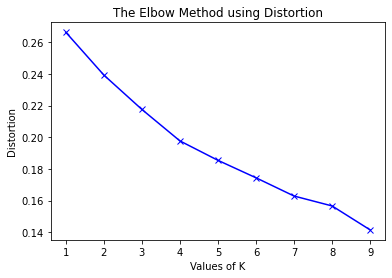

In [132]:
import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

From graph show that no significant elbow so I will choose k = 7 because it has minimum derivative at the point.

In [134]:
model = KMeans(n_clusters=7).fit(X)
model.fit(X)

KMeans(n_clusters=7)

In [136]:
labels =  model.labels_
neighborhoods_venues_sorted['Label'] = labels
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label
0,Berczy Park,Cocktail Bar,Coffee Shop,Bakery,Farmers Market,Pharmacy,Beer Bar,Cheese Shop,Restaurant,Seafood Restaurant,Pub,3
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Performing Arts Venue,Coffee Shop,Grocery Store,Burrito Place,Climbing Gym,Convenience Store,Furniture / Home Store,Gym,3
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Airport,Boat or Ferry,Rental Car Location,Coffee Shop,Sculpture Garden,Boutique,Plane,3
3,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Burger Joint,Restaurant,Bubble Tea Shop,Japanese Restaurant,Salad Place,Park,3
4,Christie,Grocery Store,Café,Park,Nightclub,Coffee Shop,Candy Store,Baby Store,Restaurant,Athletics & Sports,Italian Restaurant,6


In [138]:
merged =  neighborhoods_venues_sorted.merge(toronto,how = 'left',on =  'Neighborhood' )
merged.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label,Postal Code,Borough,Latitude,Longitude
0,Berczy Park,Cocktail Bar,Coffee Shop,Bakery,Farmers Market,Pharmacy,Beer Bar,Cheese Shop,Restaurant,Seafood Restaurant,Pub,3,M5E,Downtown Toronto,43.644771,-79.373306
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Performing Arts Venue,Coffee Shop,Grocery Store,Burrito Place,Climbing Gym,Convenience Store,Furniture / Home Store,Gym,3,M6K,West Toronto,43.636847,-79.428191
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Airport,Boat or Ferry,Rental Car Location,Coffee Shop,Sculpture Garden,Boutique,Plane,3,M5V,Downtown Toronto,43.628947,-79.394420
3,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Burger Joint,Restaurant,Bubble Tea Shop,Japanese Restaurant,Salad Place,Park,3,M5G,Downtown Toronto,43.657952,-79.387383
4,Christie,Grocery Store,Café,Park,Nightclub,Coffee Shop,Candy Store,Baby Store,Restaurant,Athletics & Sports,Italian Restaurant,6,M6G,Downtown Toronto,43.669542,-79.422564


In [141]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
kclusters = 7
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [143]:
merged.Label.value_counts()

3    31
0     3
1     1
2     1
4     1
5     1
6     1
Name: Label, dtype: int64

According Above we found that it has 2 cluster another is just point so ,
Let see what's inside .

In [149]:
cluster3 =  merged[merged.Label ==3]
cluster3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label,Postal Code,Borough,Latitude,Longitude
0,Berczy Park,Cocktail Bar,Coffee Shop,Bakery,Farmers Market,Pharmacy,Beer Bar,Cheese Shop,Restaurant,Seafood Restaurant,Pub,3,M5E,Downtown Toronto,43.644771,-79.373306
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Performing Arts Venue,Coffee Shop,Grocery Store,Burrito Place,Climbing Gym,Convenience Store,Furniture / Home Store,Gym,3,M6K,West Toronto,43.636847,-79.428191
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Airport,Boat or Ferry,Rental Car Location,Coffee Shop,Sculpture Garden,Boutique,Plane,3,M5V,Downtown Toronto,43.628947,-79.394420
3,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Burger Joint,Restaurant,Bubble Tea Shop,Japanese Restaurant,Salad Place,Park,3,M5G,Downtown Toronto,43.657952,-79.387383
5,Church and Wellesley,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Yoga Studio,Café,Fast Food Restaurant,Dance Studio,Men's Store,3,M4Y,Downtown Toronto,43.665860,-79.383160
6,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Café,Hotel,Gym,Italian Restaurant,Deli / Bodega,Seafood Restaurant,Japanese Restaurant,Bakery,3,M5L,Downtown Toronto,43.648198,-79.379817
7,Davisville,Sandwich Place,Pizza Place,Dessert Shop,Café,Italian Restaurant,Sushi Restaurant,Gym,Coffee Shop,Restaurant,Diner,3,M4S,Central Toronto,43.704324,-79.388790
8,Davisville North,Gym,Breakfast Spot,Hotel,Food & Drink Shop,Department Store,Park,Sandwich Place,Pizza Place,Gym / Fitness Center,Moroccan Restaurant,3,M4P,Central Toronto,43.712751,-79.390197
9,"Dufferin, Dovercourt Village",Pharmacy,Bakery,Music Venue,Middle Eastern Restaurant,Café,Supermarket,Bar,Bank,Brewery,Pet Store,3,M6H,West Toronto,43.669005,-79.442259
10,Enclave of M4L,Light Rail Station,Yoga Studio,Garden Center,Pizza Place,Comic Shop,Restaurant,Farmers Market,Fast Food Restaurant,Burrito Place,Skate Park,3,M7Y,East Toronto Business,43.662744,-79.321558


According to dataset above this cluster have a lot of Cafe (Cafe/Coffeeshop) , restuarant and bar(pub). it has a lot of food and drink here . 

In [150]:
cluster0   = merged[merged.Label == 0 ]
cluster0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label,Postal Code,Borough,Latitude,Longitude
13,Forest Hill North & West,Park,Trail,Jewelry Store,Sushi Restaurant,Airport,Movie Theater,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,0,M5P,Central Toronto,43.696948,-79.411307
26,Rosedale,Park,Playground,Trail,Airport,Museum,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,0,M4W,Downtown Toronto,43.679563,-79.377529
35,The Danforth East,Park,Intersection,Convenience Store,Airport,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,0,M4J,East York/East Toronto,43.685347,-79.338106


According to data above .This cluser has airport  ,store ,park,foreign restaurant . so I think this cluster may be place for foreigner after they landed from airport.

the rest of cluster are just a point in each clusters so I can't analyze them.